# Transformers for Sentiment Classification

Welcome folks!, in the current project I will show you in detail how to implement four types of well-known transformer models making use of the transformers HuggingFace library and Keras API.

The main task corresponds to a multi-class text classification on Movie Reviews Competition and the dataset contains 156.060 instances for training, whereas the testing set contains 66.292 from which we have to classify among 5 classes. The sentiment labels are:

0 → Negative

1 → Somewhat negative

2 → Neutral

3 → Somewhat positive

4 → Positive

At the end of the project we will summarize and compare their performance according to our requirements and metrics.

In [1]:
import math, re, os
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


# Load Dataset

In [3]:
train= pd.read_csv("/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip", sep="\t")
test = pd.read_csv("/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip", sep="\t")

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
train.shape,   test.shape

((156060, 4), (66292, 3))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [7]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [8]:
train["Sentiment"].value_counts()

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64

In [9]:
train["Sentiment"].value_counts(normalize=True)

Sentiment
2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: proportion, dtype: float64

<Axes: xlabel='Sentiment'>

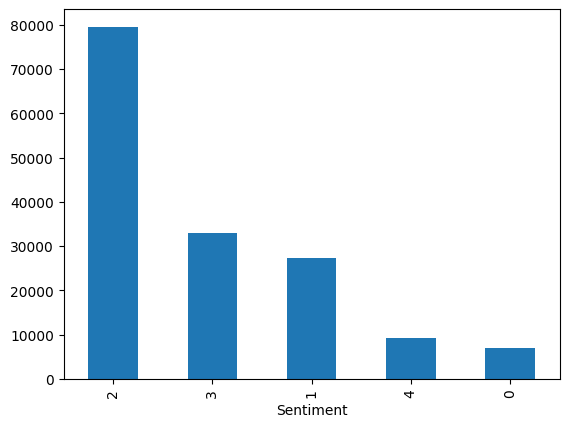

In [10]:
train["Sentiment"].value_counts().plot(kind="bar")

In [11]:
X = train['Phrase'].values


In [12]:
from tensorflow.keras.utils import to_categorical
y =train["Sentiment"].values
y=to_categorical(y)
num_classes=y.shape[1]
num_classes

5

In [13]:
y

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

# Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

### Tokenization Example For BERT



In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained( 'bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Fixing token counts of all documents

In [17]:
# For every sentence...
number_tokens_sentences = []
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    number_tokens_sentences.append(len(input_ids))

print('Max sentence length: ', max(number_tokens_sentences))
# Use the tokenizer.encode() function only to find out how many tokens the longest comment consists of and how many tokens include all comments/texts.
# We will use it to decide which token we will peg.

Max sentence length:  80


In [60]:
np.array(number_tokens_sentences).mean()

10.78316032295271

In [19]:
sum(np.array(number_tokens_sentences) <= 45) / len(number_tokens_sentences)

# we decide to fix all comments to 45 tokens.

0.9945469691144432

### Transformation Vectors to Matrices

In [20]:
# While we have a single comment/text, BERT models convert the text into a numeric version as 3 separate vectors (2 separate vectors for classificaiton problems).
# whether...or. However, if there is more than one comment, the size of the event changes. And they want matrices formed by combining vectors.
# Since our problem is classification, we need to obtain 2 separate matrices consisting of token embeddings (input_ids) and attention_mask vectors.
# To do this, we first create empty lists for input_ids and attention_mask, pull all the comments from X one by one with the for loop and get the input_ids from these comments,
# We append the attention_mask vectors into empty lists and in the last stage, we use the array() function to add these lists (number of rows, number of tokens we fixed) --> (len(X), 45)
#We convert it to matrices of size 

def transformation(X):
  # set array dimensions
  seq_len = 45

# We create the Xids empty list for input_ids and the Xmask empty list for attention_masks.
  Xids = []
  Xmask = []

    
  for sentence in X: # We pull all comments from the corpus in order.

      tokens = tokenizer.encode_plus(sentence, max_length=seq_len, truncation=True,
                                      padding='max_length', add_special_tokens=True) 
     # We convert each comment we capture into vectors.
      
       # assign tokenized outputs to respective rows in numpy arrays
      Xids.append(tokens['input_ids']) 
      Xmask.append(tokens['attention_mask']) 

  return np.array(Xids), np.array(Xmask) # We are converting Xids and Xmask matrices (number of comments, 45) to np.array format for faster execution.

In [21]:
# We are organizing 2 separate matrices for our train set.
# We are organizing 2 separate matrices for our test set.

Xids_train, Xmask_train = transformation(X_train)

Xids_val, Xmask_val = transformation(X_val)




In [22]:
Xids_train

array([[  101, 11937, 24168, ...,     0,     0,     0],
       [  101,  2012,  2540, ...,     0,     0,     0],
       [  101, 23362,   102, ...,     0,     0,     0],
       ...,
       [  101,  1037,  2919, ...,     0,     0,     0],
       [  101,  2471,  2196, ...,     0,     0,     0],
       [  101,  2013,  2707, ...,     0,     0,     0]])

In [23]:
print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print("Xids_val.shape   :", Xids_val.shape)
print("Xmask_val.shape  :", Xmask_val.shape)

Xids_train.shape  : (140454, 45)
Xmask_train.shape : (140454, 45)
Xids_val.shape   : (15606, 45)
Xmask_val.shape  : (15606, 45)


In [24]:
y_train
# BERT models also require the target as a matrix. For this reason, we transform our y_train target into a matrix of size (len(y_train), 5).

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [61]:
y_val

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## Transformation Matrix to Tenserflow Tensor

In [26]:
import tensorflow as tf

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, y_train))
dataset_train

# The last step before exporting the data to BERT models is to convert the matrices we obtained above into grouped Tensorflow tensors.
# A tensor is a mathematical structure that represents a collection of data in one or more dimensions. One-dimensional tensor as vector, 2-dimensional tensor as matrix,
# Tensors of dimension 3 and larger are referred to as high-dimensional tensors.

# Tensorflow tensors enable hardware such as GPU/TPU to run faster or perform operations such as parallel processing more effectively.
# TensorFlow tensors can also use automatic differentiation features provided by the TensorFlow library. However, numpy.array() cannot provide these operations.
# We convert it to Tensors with the Tesorflow library.

# Additionally, the tf.data.Dataset.from_tensor_slices function converts the Xids_train, Xmask_train, labels_train matrices into grouped tensors. The model thus consists of these 3 tensors
# will understand that they represent the same data.

# In this context, we will convert the 3 separate matrices we obtained above for the train data into grouped Tensorflow tensors.

<_TensorSliceDataset element_spec=(TensorSpec(shape=(45,), dtype=tf.int64, name=None), TensorSpec(shape=(45,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))>

In [27]:
dataset_val = tf.data.Dataset.from_tensor_slices((Xids_val, Xmask_val, y_val))
dataset_val

# Just like we did for the train data, we will convert our 3 separate matrices into grouped Tensorflow tensors for the test data.

<_TensorSliceDataset element_spec=(TensorSpec(shape=(45,), dtype=tf.int64, name=None), TensorSpec(shape=(45,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))>

In [28]:
def map_func(Tensor_Xids, Tensor_Xmask, Tensor_labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Tensor_Xids, 'attention_mask': Tensor_Xmask}, Tensor_labels
  
# The model cannot know which of the tensors we obtained above is 'input_ids', which is 'attention_mask' and which is labels. Therefore
# we need to provide this information to our model. For this, we define the function above.
# We define 'input_ids' and 'attention_mask' in curly brackets. We leave Labels outside the curly brackets.

In [29]:
# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_val = dataset_val.map(map_func) 

# We apply the function we defined above to all train and test data with map.
# Conversions are also made in the form of dataset_train.map(map_func) and dataset_val.map(map_val). 

In [30]:
print(dataset_train)
len(dataset_train)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(45,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(45,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float32, name=None))>


140454

In [31]:
dataset_val

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(45,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(45,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float32, name=None))>

## Batch Size Train and Validation Dataset

In [32]:
batch_size = 32


# fit into a batch of 32
train_ds = dataset_train.batch(batch_size)
val_ds = dataset_val.batch(batch_size)
# Batch_size numbers 16 and 32 have been recommended by the developers who developed the BERT model.
# We determine that we will give the grouped tensors we obtained above to the model in how many packages. We do this with the batch() function.
#We want it to be given to the model in packages of #32. We apply it to both train and val data.

In [33]:
print(train_ds)
len(train_ds)

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 45), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 45), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


4390

https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert


If we want, we can create the optimizer with a function ourselves and integrate it into our model.
#!pip install -q tf-models-official

from official.nlp import optimization


epochs = 1
#batch_size = 32
steps_per_epoch = len(train_ds)

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5  # 3e-5, 5e-5
optimizer= optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')  


In [35]:
print(len(train_ds)*3)
print(int(0.1*len(train_ds)*3))

13170
1317


## Creating Model

In [36]:
@tf.autograph.experimental.do_not_convert

def create_model():
    from transformers import TFAutoModel
    
    
    

    model = TFAutoModel.from_pretrained("bert-base-uncased") 


    input_ids = Input(shape=(45,), name='input_ids', dtype='int32')
    attention_mask = Input(shape=(45,), name='attention_mask', dtype='int32')
   

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] 
 

    x = Dense(45, activation='relu')(embeddings)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x) #0.1 ratio is the ratio recommended by developers.
    y = Dense(5, activation='softmax', name='outputs')(x)


    return Model(inputs=[input_ids, attention_mask], outputs=y)


In [41]:


# Legacy Adam optimizer'ını oluşturun
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
#categorical_crossentropy
loss = CategoricalCrossentropy()
recall = Recall()

model3 = create_model()

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [42]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 45)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 45)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 45, 76                                     

In [43]:

model3.fit(train_ds, validation_data= val_ds, epochs=2)
# The accuracy and val_accuracy metrics returned by the model are values belonging to the weight class.

# The loss value shows how likely the model is to make its predictions. If the model made all its predictions with a probability of 1.0, the loss value will be 0.
# loss = 1/n x (log(probability_1) + log(probability_2) + log(probability_3)+......+ log(probability_n))
# loss and val_loss values return the common score of all classes. Therefore, in very unbalanced datasets, the loss value of the majority class will be more weighted.
# Overfitting decisions are not made by looking at loss and val_loss values. However, if class_weight is made, loss values can be taken into account.
# Overfitting decision is made according to recall and precision metrics.

Epoch 1/2
4390/4390 [==============================] - 928s 206ms/step - loss: 1.0372 - accuracy: 0.6434 - val_loss: 0.9490 - val_accuracy: 0.6749
Epoch 2/2
4390/4390 [==============================] - 901s 205ms/step - loss: 0.9339 - accuracy: 0.6779 - val_loss: 0.9451 - val_accuracy: 0.6808


## Model evaluation

In [44]:
model_loss = pd.DataFrame(model3.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,1.037197,0.643413,0.949014,0.674869
1,0.933899,0.677887,0.945080,0.680828


<Axes: >

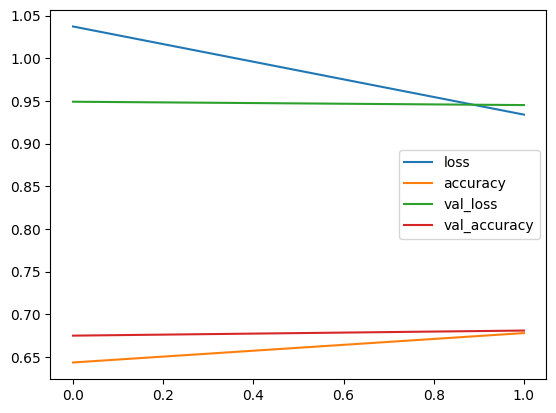

In [62]:
model_loss.plot()

In [46]:
model3.evaluate(train_ds)

4390/4390 [==============================] - 326s 74ms/step - loss: 0.8794 - accuracy: 0.7008


[0.8794422149658203, 0.7007917165756226]

In [47]:
model3.evaluate(val_ds)

488/488 [==============================] - 36s 74ms/step - loss: 0.9451 - accuracy: 0.6808


[0.9450802206993103, 0.6808279156684875]

In [48]:

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model3.predict(val_ds) 

y_val_preds = np.argmax(y_val_pred, axis=1)#So one number for each observation, this number represents the predicted class of that observation
y_val_true = np.argmax(y_val, axis=1)


print(classification_report(y_val_true, y_val_preds))

#Here y_val_pred is an array containing the predicted class for each sample
#will happen. The argmax function returns the index of the class with the highest probability for each sample

488/488 [==============================] - 38s 72ms/step
              precision    recall  f1-score   support

           0       0.52      0.41      0.46       707
           1       0.54      0.65      0.59      2727
           2       0.79      0.76      0.78      7958
           3       0.61      0.61      0.61      3293
           4       0.58      0.53      0.55       921

    accuracy                           0.68     15606
   macro avg       0.61      0.59      0.60     15606
weighted avg       0.69      0.68      0.68     15606



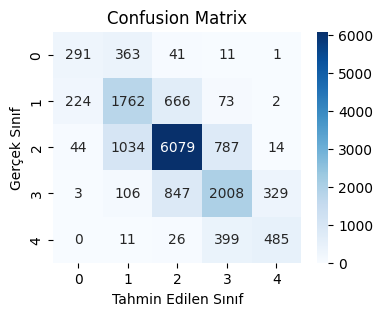

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt




cm = confusion_matrix(y_val_true, y_val_preds)


plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2,3,4], yticklabels=[0, 1, 2,3,4])
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [50]:

y_train_pred = model3.predict(train_ds)



y_train_preds = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(y_train, axis=1)


print(classification_report(y_train_true, y_train_preds))



4390/4390 [==============================] - 317s 72ms/step
              precision    recall  f1-score   support

           0       0.54      0.44      0.49      6365
           1       0.57      0.67      0.62     24546
           2       0.81      0.78      0.80     71624
           3       0.63      0.62      0.63     29634
           4       0.60      0.56      0.58      8285

    accuracy                           0.70    140454
   macro avg       0.63      0.61      0.62    140454
weighted avg       0.71      0.70      0.70    140454



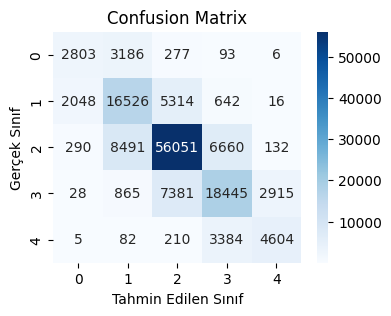

In [51]:


cm = confusion_matrix(y_train_true, y_train_preds)


plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2,3,4], yticklabels=[0, 1, 2,3,4])
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()



488/488 [==============================] - 35s 72ms/step


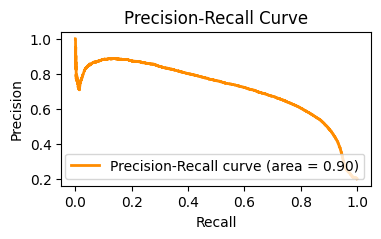

In [52]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score

y_pred_proba = model3.predict(val_ds)
auc_score = roc_auc_score(y_val.ravel(), y_pred_proba.ravel())
precision, recall, _ = precision_recall_curve(y_val.ravel(), y_pred_proba.ravel())

plt.figure(figsize=(4, 2))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(auc_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()



In [53]:
#model3.save_weights("/content/drive/MyDrive/sentiment_model.h5")
 
# We save the model weights/coefficients we obtained after training by giving the drive path/name with the save_weights function.

In [54]:
#model4 = create_model()
#model4.load_weights("/content/drive/MyDrive/sentiment_model.h5")

## Predictions

In [55]:
# We apply the same process of converting train and validation data into grouped tensorflow tensors to the observations (obs) that we will predict, respectively.

def prep_data(text):
  import tensorflow as tf
  
  # 1. We first convert the new observations we will predict into token embeddings (input_ids) and attention_mask matrices.
   # Remember that in order to use this function, you must first run the transformation function.
  Xids_obs, Xmask_obs = transformation(text) 
  
  # 2. We convert our Xids_obs, Xmask_obs matrices into grouped tensorflow tensors.
  dataset_obs = tf.data.Dataset.from_tensor_slices((Xids_obs, Xmask_obs))
  
  # 3. We name the grouped tensorflow tensors we converted as "input_ids" and "attention_mask" so that the model can recognize them.
  def map_func(Tensor_Xids, Tensor_Xmask):
       return {'input_ids': Tensor_Xids, 'attention_mask': Tensor_Xmask}
  
  dataset_obs = dataset_obs.map(map_func)

  # 4. As the last step, we turn our grouped tensorflow tensors into 32 packages, just like in the train data. Otherwise, we will get a shape incompatibility error. 
  batch_size = 32 
  obs_ds = dataset_obs.batch(batch_size)

  return obs_ds 




In [56]:

test_texts = test["Phrase"].astype(str).tolist()
test_ds = prep_data(test_texts)


y_pred = model3.predict(test_ds)


y_preds = np.argmax(y_pred, axis=1)


test["Predictions"] = y_preds


2072/2072 [==============================] - 152s 72ms/step


In [57]:
test

,PhraseId,SentenceId,Phrase,Predictions
0,156061,8545,An intermittently pleasing but mostly routine ...,3
1,156062,8545,An intermittently pleasing but mostly routine ...,3
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,3
4,156065,8545,intermittently pleasing but mostly routine,3
...,...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario .",1
66288,222349,11855,"A long-winded , predictable scenario",1
66289,222350,11855,"A long-winded ,",2
66290,222351,11855,A long-winded,2


In [58]:
#make the predictions with trained model and submit the predictions.


sub_file = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_preds
sub_file.to_csv('Submission.csv',index=False)

In [59]:
sub_file

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
...,...,...
66287,222348,1
66288,222349,1
66289,222350,2
66290,222351,2
